Yammer user engagement is analyzed in the period between May and September 2014,
to find the potential causes for decrease in user engagement starting from August 1st.

The available data consists of four tables:
1. users tables, containing information about when the
user account was created, its status (active or not), company and language,
2. events table, containing information on event types (such as user creation, home page loading, ...)
location and device,
3. emails table, containing information on which kind of email the user was sent (such as weekly digest, email clickthrough,...)
4. rollup periods, a lookup table containing rolling time periods.

**Methodology**

Loss in engagement can be caused by either user related issues (such as people just stopped signing up
for the app) or app related issues (such as a change in the emailing system or app functionality,
that could have been caused by either a bug in the app or a marketing decision).
Also, the cause for loss of engagement can be a combination of both the problems mentioned above.

To investigate user related issues, the time series of the number of signups per day is
plotted, to spot any significant/interesting trend. Only the users table is leveraged for this.

To investigate app related issues, 'intervention analysis' is used to determine if there have been
any significant changes in the app in the period leading to August 1st 2014.
The time-period 'leading to' when the change in engagement is noticed is determined looking at the average time
of interaction of the user with the app, which is of about 18 days (suggesting already that
the app struggles to keep users engaged in general).

Because users interact with the app for 18 days, this is the time period in which any
significant change might be noticed.

The code for the intervention analysis in the following is based on this article:
https://towardsdatascience.com/what-is-the-strongest-quasi-experimental-method-interrupted-time-series-period-f59fe5b00b31.

The times series used to perform the intervention analysis are produced joining the users, emails and events tables on
the user id field. This gives a comprehensive view of the user-app interaction and can be leveraged to
determine the average time that the user is engaged with the app. This information, as mentioned,
is used to define the time period significant to evaluate the changes in the app.

While the user table spans over a year, the events and emails tables span a much shorter time period (May to September 2014).
The data is however sufficient to deliver business insights, because the average user-app interaction time is of
about 18 days.

The data sets are loaded into pandas dataframe and inspected to further understand the
columns data types.


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-white')

In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [237]:
import pandas as pd

emails = pd.read_excel("yammer_emails.xlsx")

events = pd.read_excel("yammer_events.xlsx")

users = pd.read_excel("yammer_users.xlsx")

In [5]:
print(emails.info())
print(events.info())
print(users.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      90389 non-null  int64         
 1   occurred_at  90389 non-null  datetime64[ns]
 2   action       90389 non-null  object        
 3   user_type    90389 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340832 entries, 0 to 340831
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      340832 non-null  int64         
 1   occurred_at  340832 non-null  datetime64[ns]
 2   event_type   340832 non-null  object        
 3   event_name   340832 non-null  object        
 4   location     340832 non-null  object        
 5   device       340832 non-null  object        
 6   user_type

Pandas profiling is used to perform some preliminary EDA.

From the profiling, the columns that will be used for the analysis have no missing values, so that no imputation strategy has to be laid out.

The number of user sign-ups is largely the same as the number of active users, so it will be assumed
that all the users that signed up have their profile activated.

In [6]:
profile = ProfileReport(emails, title='Pandas Profiling Report')
profile.to_file(output_file='emails.html')
profile = ProfileReport(events, title='Pandas Profiling Report')
profile.to_file(output_file='events.html')
profile = ProfileReport(users, title='Pandas Profiling Report')
profile.to_file(output_file='users.html')

While the user table spans a period between 2013 and 2014, the other two contain data only between May and September 2014.
Also, the emails and events tables are contain all the user-specific interactions,
meaning that while the user id is unique in the user tables, a user can appear in the other two tables
multiple times.

Therefore, to gain insight into the user sign-ups from January 2013 to September 2014,
we only use the users table. Afterwards, the user table is merged with the events and emails tables.


As a first approach, we are only looking at the date of the interaction (whether that is a signup
or an email sent),
without descending into the details of day of the week or the hour of the interaction.
However, a future iteration of the analysis should also contain these information, because
the lack of engagement might very well be connected to a change in emailing hours for example.

In [246]:
users['created_at'] = users['created_at'].dt.date
users['activated_at'] = users['activated_at'].dt.date

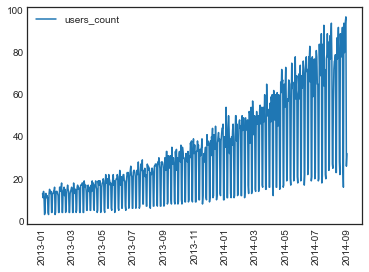

In [249]:
df_usr_count = users.groupby(['created_at']).count()
df_usr_count = df_usr_count.reset_index()
df_usr_count['users_count'] = df_usr_count['user_id']
df_usr_count.plot(x='created_at', y='users_count', rot= 90)
plt.xlabel("")
plt.show()



The users table is now merges with emails and events tables, and also in this case only the date
is extracted from the events and emails timestamps.

In [ ]:
user_events = users.merge(events, on = 'user_id', suffixes = ('_usr', '_events'))
df = user_events.merge(emails, on = 'user_id', suffixes = ('_usr_events', '_emails'))

A profiling report is also produced for the joined dataframe.

In [11]:
profile = ProfileReport(df, title='df')
profile.to_file(output_file='df.html')

In [239]:
df['occurred_at_usr_events'] = df['occurred_at_usr_events'].dt.date
df['occurred_at_emails'] = df['occurred_at_emails'].dt.date

We can now look at the user-app interaction time, and gain insight into the user average
interaction time with the app.

An interaction is defined as login event: if the user log into the app
then we consider that as an interaction. All other events are discarded.

The user's interaction time is considered to be the
difference in days between the first ever login and the most recent one is considered.

Text(0, 0.5, 'frequency')

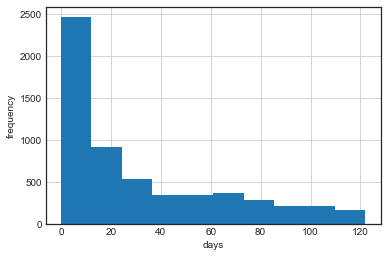

In [250]:
df_avg_eng = df[df['event_name'] == 'login']
df_max = df_avg_eng.groupby('user_id')['occurred_at_usr_events'].max()
df_max = df_max.reset_index()
df_min = df_avg_eng.groupby('user_id')['occurred_at_usr_events'].min()
df_min = df_min.reset_index()

df_avg = df_max.merge(df_min, on= 'user_id', suffixes = ('_max', '_min'))
df_avg['time_diff'] = df_avg['occurred_at_usr_events_max'] - df_avg['occurred_at_usr_events_min']

df_avg['time_diff'] = df_avg['time_diff'].dt.days.astype(int)
ax = df_avg['time_diff'].hist()
ax.set_xlabel("days")
ax.set_ylabel("frequency")

In [253]:
avg_int_time = df_avg['time_diff'].median()
print(avg_int_time)

18.0


The distribution is highly skewed towards the left, suggesting that most of the users do not stay engaged
for more than 10 days. Also, given the skewed distribution, the average time of user-app interaction
is considered to be the median of the interaction times.

As a result, 18 days is considered as the benchmark for evaluating any significant changes in the app.
Specifically, suppose we want to look into the number of weekly digest emails sent to the user because
we suspect that those changed, and that lead to disengagement. The strategy is to compare the time series
of the number of weekly digest email sent from May 2014 to July 13 2014, and compare it with the time
series from July 13 to August 1 2014. Basically we are trying to see if in the time interval significant
for user-app interaction (18 days) there was any kind of intervention (such as changing the number of weekly digest emails sent)
that might justify the lack of engagement observed from August 1st.

This approach assumes no changes in the app between May 1st 2014 and July 13th 2014: another iteration of this same analysis
should also look into that.

The parameters we look at are:
1. events (such as significant changes in number of complete signups,
 entering email,
 entering user info,
 liking a message),
2. location (did the app usage change in any specific location? This might suggest local malfunctioning of the app that,
depending on the number of local users, may or may not translate on a lack of overall engagement)
3. device (did the app suddenly stop working for specific devices?)
4. emails (did the number of emails of any category change significantly?)


In [262]:
#https://towardsdatascience.com/what-is-the-strongest-quasi-experimental-method-interrupted-time-series-period-f59fe5b00b31
import statsmodels.formula.api as smf
from datetime import date
def significant_changes(df_i, col, time_col, lst=None):
    df_i = df_i[df_i[time_col] < date(2014, 8, 1)]
    significant_changes = []
    if lst is None:
        lst = df_i[col].unique()
    else:
        lst = lst
    for i in lst:
        df = df_i[df_i[col]==i]
        df['intervention'] = (df[time_col]> date(2014, 7, 13))
        df['intervention'] = df['intervention'].astype(int)
        mod = smf.ols(formula ='count ~ intervention', data=df)

        res = mod.fit()

        if res.pvalues[1] < 0.05:

            significant_changes.append(i)
    print('Number of categories:', len(lst) ,' Categories with significant changes:', len(significant_changes))
    return significant_changes

In [215]:
def plot_trends(df, col, time_col, lst=None):
    if lst is None:
        df=df
    else:
        lst = lst
        df = df[df[col].isin(lst)]

    fig, ax = plt.subplots()
    for key, data in df.groupby(col):
        data.plot(x=time_col, y='count',ax = ax, label=key, rot = 90)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=5)
    plt.show()

In [196]:
def df_transform(df, col, time_col):
    df_out = df.groupby([time_col,col])['user_id'].count()
    df_out = df_out.reset_index()
    df_out['count'] = df_out['user_id']
    df_out.drop(columns=['user_id'], inplace = True)
    return df_out

In [255]:
df_event_count = df_transform(df, 'event_name', 'occurred_at_usr_events')

None


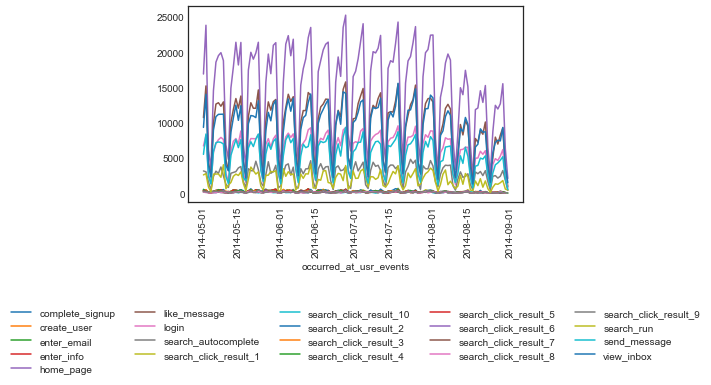

In [256]:
plot_trends(df_event_count, 'event_name', 'occurred_at_usr_events')

In [263]:
significant_changes(df_event_count, 'event_name', 'occurred_at_usr_events')


Number of categories: 21  Categories with significant changes: 4


['complete_signup', 'create_user', 'enter_email', 'enter_info']

In the designated time period there have been changes in complete signup (users completion
of authentication process), number of created users (when users are
inserted into Yammer database),
email and info entered.

Plotting these fields all together, it is clear how all these fields decline steadily at the same pace.
The number of users that sign up, on the other hand, steadily increases: this suggests that there might be
an internal problem on the app that compromises the user onboarding process.

['complete_signup', 'create_user', 'enter_email', 'enter_info']


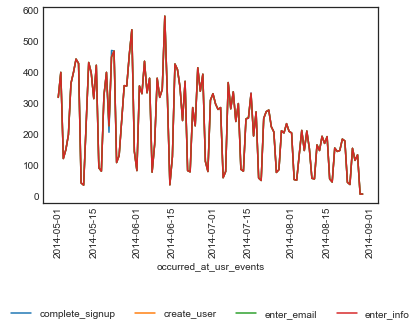

In [267]:
plot_trends(df_event_count, 'event_name', 'occurred_at_usr_events', lst=['complete_signup', 'create_user', 'enter_email', 'enter_info'])

In [258]:
df_event_loc = df_transform(df, 'location', 'occurred_at_usr_events')


['United States', 'Japan', 'Germany', 'France', 'United Kingdom']


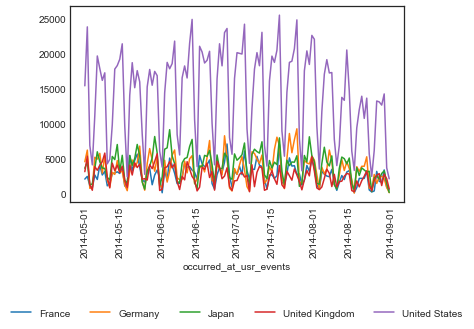

In [259]:
locs = ['United States', 'Japan', 'Germany','France', 'United Kingdom']

plot_trends(df_event_loc, 'location', 'occurred_at_usr_events', lst = locs)

In [268]:
significant_changes(df_event_loc, 'location', 'occurred_at_usr_events')

Number of categories: 47  Categories with significant changes: 8


['Chile',
 'Denmark',
 'Finland',
 'Germany',
 'Italy',
 'Spain',
 'United Arab Emirates',
 'Switzerland']

The analysis suggests significant changes in app usage in a few countries. However,
the traffic from these countries accounts for 15% of the total traffic, casting doubts on the statistical significance
of this result, which requires further testing.

In [270]:
countries = ['Chile',
 'Denmark',
 'Finland',
 'Germany',
 'Italy',
 'Spain',
 'United Arab Emirates',
 'Switzerland']

df_countries = df[df['location'].isin(countries)]
print('% of countries where significant change happened', len(df_countries)*100/len(df))

% of countries where significant change happened 15.082366835936273


In [208]:
df_device = df_transform(df, 'device', 'occurred_at_usr_events')

['macbook pro', 'lenovo thinkpad', 'macbook air', 'iphone 5', 'dell inspiron notebook']


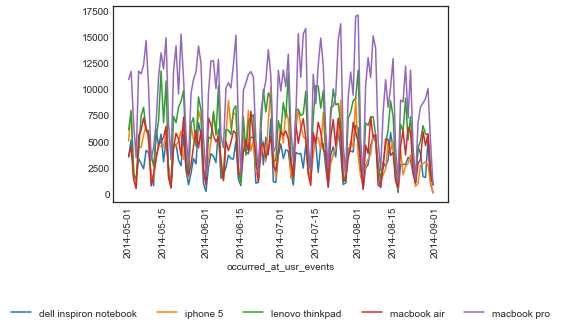

In [217]:
devs = ['macbook pro', 'lenovo thinkpad', 'macbook air', 'iphone 5', 'dell inspiron notebook']

plot_trends(df_device, 'device', 'occurred_at_usr_events', lst = devs)

In [271]:
significant_changes(df_device, 'device', 'occurred_at_usr_events')


Number of categories: 26  Categories with significant changes: 0


[]

The analysis does not highlight any significant issues in the app usage per different devices.

In [211]:
df_email = df_transform(df, 'action', 'occurred_at_emails')

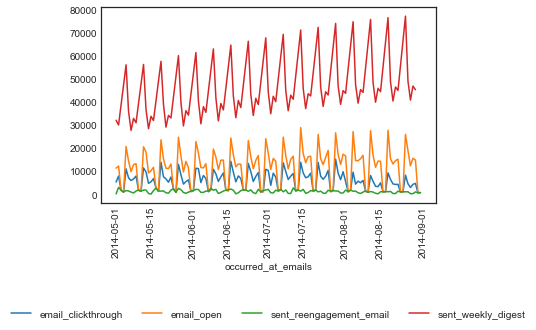

In [212]:
plot_trends(df_email, 'action', 'occurred_at_emails')

In [272]:
significant_changes(df_email, 'action', 'occurred_at_emails')


Number of categories: 4  Categories with significant changes: 1


['sent_weekly_digest']

The analysis highlight a change in weekly digest emails. However it is clear from the plot how the number of emails sent
follows a trend of steady increase. It is possible that an increasing number of weekly digest emails puts off users, that
become less and less prone to interact with the app.



**Conclusions**
Observing the number of user sign-ups per day, it appears that there number of users sign-ups grows pretty
steadily in time, suggesting that the app does not lack new users. The lack of users is therefore ruled out
as a potential cause for lack of engagement.

The average user-app interaction time is of about 18 days, already suggesting that
while it is easy for Yammer to have new users signup,
the app struggles to
keep them engaged.





